In [2]:
from hypnettorch.data.special.regression1d_data import ToyRegression
from hypnettorch.utils import misc
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial.distance import cdist
from sklearn.datasets import make_moons
from sklearn.gaussian_process.kernels import RBF
import sys
from time import time
import torch

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from nngp import MLPKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = 'cpu'

ts, lw, ms = 15, 8, 140 # text fontsize, line width, marker size
figsize = (12, 6)

In [3]:
def compute_kernels(data, config_dict):
    # Compute kernel matrices.
    for k in config_dict:
        start = time()
        if k['name'] == 'rbf':
            rbf_kernel = RBF()
            K = rbf_kernel(data.detach().cpu().numpy())
        else:
            mlp_kernel = MLPKernel(sigma2_w=1., sigma2_b=1., **k['params'])
            if k['name'].startswith('analytic'):
                K = mlp_kernel.kernel_analytic(data, **k['kernel_params']).numpy() 
            elif k['name'].startswith('efficient'):
                K = mlp_kernel.kernel_efficient(data, **k['kernel_params']).numpy()
            else:
                K = mlp_kernel.kernel_mc(data, **k['kernel_params']).numpy() 
        k['kernel'] = K
        print('Kernel "%s" computation took %f seconds.' % (k['name'], time()-start))

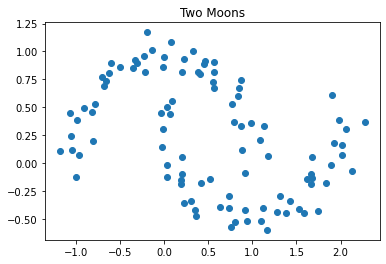

In [4]:
X, Y = make_moons(n_samples=100, shuffle=True, noise=.1, random_state=42)

plt.title('Two Moons')
plt.scatter(X[:,0], X[:,1])
plt.show()

In [5]:
kernels = [
    ######################
    ### Common Kernels ###
    ######################
    {'name': 'rbf', 'plot_lbl': 'RBF'},
    ####################
    ### NNGP Kernels ###
    ####################
    ### Relu ###
    {'name': 'analytic_relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}, 'plot_lbl': 'ReLU 1-layer'},
    {'name': 'analytic_relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}, 'plot_lbl': 'ReLU 2-layer'},
    ### Tanh ###
    {'name': 'tanh_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {'num_samples': 100000}, 'plot_lbl': 'Tanh 1-layer'},
    {'name': 'tanh_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.Tanh()},
     'kernel_params': {'num_samples': 100000}, 'plot_lbl': 'Tanh 2-layer'},
]

X_moon = torch.Tensor(X).to(device)
kernels_moon = [dict(k) for k in kernels]
compute_kernels(X_moon, kernels_moon)

Kernel "rbf" computation took 0.000365 seconds.
Kernel "analytic_relu_1l" computation took 0.036546 seconds.
Kernel "analytic_relu_2l" computation took 0.001380 seconds.
Kernel "tanh_1l" computation took 1.472103 seconds.
Kernel "tanh_2l" computation took 2.833893 seconds.


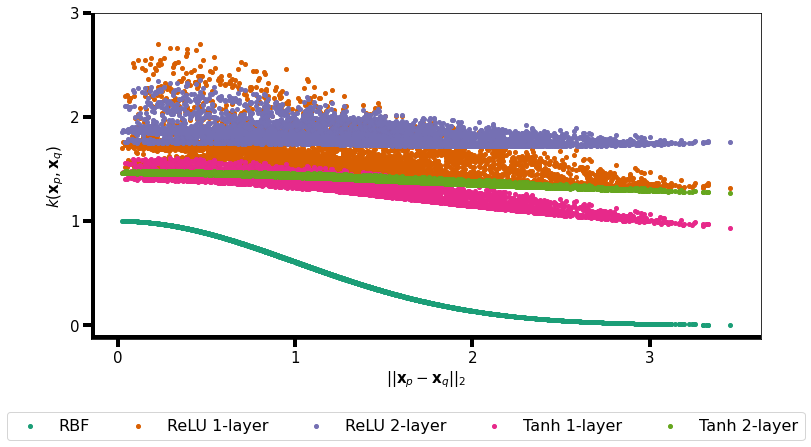

In [6]:
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter, MaxNLocator

def kernel_val_vs_distance(data, kernel_dicts):
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    edits = cdist(data, data, metric='euclidean')
    triu_inds = np.triu_indices(edits.shape[0], k=1)
    triu_edits = edits[triu_inds]
    sorted_inds = np.argsort(triu_edits)

    colors = misc.get_colorbrewer2_colors(family='Dark2')
    
    small_font = FontProperties()
    small_font.set_size(16)
    
    fig, axes = plt.subplots(figsize=figsize)
    
    #plt.title('Kernel value vs Euclidean distance')
    
    for i, k in enumerate(kernel_dicts):
        plt.scatter(triu_edits[sorted_inds],
            k['kernel'][triu_inds][sorted_inds],
            c=colors[i], s=lw*2,
            label=k['plot_lbl'])
    plt.legend(prop=small_font, loc='upper center', 
               bbox_to_anchor=(0.47, -0.2), ncol=5)
    plt.ylabel('$k(\mathbf{x}_p, \mathbf{x}_q)$', fontsize=ts)
    plt.xlabel('$|| \mathbf{x}_p - \mathbf{x}_q ||_2$', fontsize=ts)
    
    axes.grid(False)
    axes.set_facecolor('w')
    axes.axhline(y=axes.get_ylim()[0], color='k', lw=lw)
    axes.axvline(x=axes.get_xlim()[0], color='k', lw=lw)
    plt.xticks([0, 1, 2, 3], fontsize=ts)
    plt.yticks([0, 1, 2, 3], fontsize=ts)
    axes.tick_params(axis='both', length=lw, direction='out', width=lw/2.)

    filename = 'distance_awareness'
    if filename is not None:
        fpath = filename
        plt.savefig(fpath + '.pdf', bbox_inches='tight')
        plt.savefig(fpath + '.png', bbox_inches='tight')
    
    plt.show()

kernel_val_vs_distance(X_moon, kernels_moon)